In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import zscore 
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler 
import statsmodels.api as sm # type: ignore 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Wczytanie Datasetu 
url = "https://github.com/JanPawlicki21/MAD_SWPS_JAN_PAWLICKI_3/raw/refs/heads/main/Mobiles%20Dataset%20(2025).csv"
df = pd.read_csv(url, sep=',', encoding='ISO-8859-1')

# Wyświetlenie pierwszych rekordów 
print(df.head())


  Company Name            Model Name Mobile Weight  RAM Front Camera  \
0        Apple       iPhone 16 128GB          174g  6GB         12MP   
1        Apple       iPhone 16 256GB          174g  6GB         12MP   
2        Apple       iPhone 16 512GB          174g  6GB         12MP   
3        Apple  iPhone 16 Plus 128GB          203g  6GB         12MP   
4        Apple  iPhone 16 Plus 256GB          203g  6GB         12MP   

  Back Camera   Processor Battery Capacity Screen Size  \
0        48MP  A17 Bionic         3,600mAh  6.1 inches   
1        48MP  A17 Bionic         3,600mAh  6.1 inches   
2        48MP  A17 Bionic         3,600mAh  6.1 inches   
3        48MP  A17 Bionic         4,200mAh  6.7 inches   
4        48MP  A17 Bionic         4,200mAh  6.7 inches   

  Launched Price (Pakistan) Launched Price (India) Launched Price (China)  \
0               PKR 224,999             INR 79,999              CNY 5,799   
1               PKR 234,999             INR 84,999              

In [3]:
# Podstawowe informacje o danych 
df.info() 
# Sprawdzenie czy są braki w kolumnach 
df.isnull().sum() 
# Typy danych 
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Company Name               930 non-null    object
 1   Model Name                 930 non-null    object
 2   Mobile Weight              930 non-null    object
 3   RAM                        930 non-null    object
 4   Front Camera               930 non-null    object
 5   Back Camera                930 non-null    object
 6   Processor                  930 non-null    object
 7   Battery Capacity           930 non-null    object
 8   Screen Size                930 non-null    object
 9   Launched Price (Pakistan)  930 non-null    object
 10  Launched Price (India)     930 non-null    object
 11  Launched Price (China)     930 non-null    object
 12  Launched Price (USA)       930 non-null    object
 13  Launched Price (Dubai)     930 non-null    object
 14  Launched Y

Company Name                 object
Model Name                   object
Mobile Weight                object
RAM                          object
Front Camera                 object
Back Camera                  object
Processor                    object
Battery Capacity             object
Screen Size                  object
Launched Price (Pakistan)    object
Launched Price (India)       object
Launched Price (China)       object
Launched Price (USA)         object
Launched Price (Dubai)       object
Launched Year                 int64
dtype: object

In [4]:
df_main = df.copy()

cols = [
    'Company Name','Model Name','Mobile Weight','RAM',
    'Front Camera','Back Camera','Processor',
    'Battery Capacity','Screen Size','Launched Price (USA)'
]
selected_df = df_main[cols].copy()
# Proces zamiany stringu na float - zostawienie samej dany numerycznej 
for col in cols:
    if col == 'Launched Price (USA)':
        selected_df[col] = (
            selected_df[col].astype(str)
            .str.replace(r'[^\d,\.]', '', regex=True)  
            .str.replace(',', '', regex=False)          
            .astype(float)
        )
    elif col in ['Company Name', 'Model Name', 'Processor']:
        continue
    else:
        selected_df[col] = (
            selected_df[col].astype(str)
            .str.extract(r'(\d+(?:\.\d+)?)')[0]
            .astype(float)
        )

# usuwanie duplikatów 
selected_df = selected_df.drop_duplicates().reset_index(drop=True)
# kolumny numeryczne 
numeric_cols = selected_df.select_dtypes(include=[np.number]).columns

# Obliczenie z-score
zs = (selected_df[numeric_cols] - selected_df[numeric_cols].mean()) \
     / selected_df[numeric_cols].std(ddof=0)

mask = zs.abs().lt(3).all(axis=1)
print(f"Usuniętych outlierów: {len(mask) - mask.sum()}")

cleaned_df = selected_df[mask].reset_index(drop=True)
print(f"Rozmiar: przed = {selected_df.shape}, po = {cleaned_df.shape}\n")

# Konwersja do tablicy NumPy
data_np = cleaned_df.to_numpy()
print("Ostateczny kształt tablicy NumPy:", data_np.shape)


Usuniętych outlierów: 65
Rozmiar: przed = (915, 10), po = (850, 10)

Ostateczny kształt tablicy NumPy: (850, 10)


In [5]:
# Przeprowadze analize statystyczną dotyczączej cen na rynku amerykańskim telefonów marki iphone i samsung
print(data_np.tolist())
company_name = data_np[:, 0] 

samsung = np.char.lower(company_name.astype(str)) =='samsung'
samsung_prices = data_np[samsung, 9].astype(float)

iphone = np.char.lower(company_name.astype(str)) == 'apple'
iphone_prices = data_np[iphone, 9].astype(float) 

# średnia 
print(f"Średnia cen iphone: {np.mean(iphone_prices):.2f} USD") 
print(f"Średnia cen samsung : {np.mean(samsung_prices):.2f} USD") 
# Mediana 
print(f"Mediana cen iphone: {np.median(iphone_prices):.2f} USD") 
print(f"Mediana cen samsung: {np.median(samsung_prices):.2f} USD")
# MIN
print(f"Min cen iphone: {np.min(iphone_prices):.2f} USD")
print(f"Min cen samsung: {np.min(samsung_prices):.2f} USD")
# MAKS
print(f"Maks cen iphone: {np.max(iphone_prices):.2f} USD")
print(f"Maks cen samsung: {np.max(samsung_prices):.2f} USD")
# Odchylenie standardowe 
print(f"Odch.std cen iphone: {np.std(iphone_prices):.2f} USD ")
print(f"Odch.std cen samsung: {np.std(samsung_prices):.2f} USD ")

[['Apple', 'iPhone 16 128GB', 174.0, 6.0, 12.0, 48.0, 'A17 Bionic', 3.0, 6.1, 799.0], ['Apple', 'iPhone 16 256GB', 174.0, 6.0, 12.0, 48.0, 'A17 Bionic', 3.0, 6.1, 849.0], ['Apple', 'iPhone 16 512GB', 174.0, 6.0, 12.0, 48.0, 'A17 Bionic', 3.0, 6.1, 899.0], ['Apple', 'iPhone 16 Plus 128GB', 203.0, 6.0, 12.0, 48.0, 'A17 Bionic', 4.0, 6.7, 899.0], ['Apple', 'iPhone 16 Plus 256GB', 203.0, 6.0, 12.0, 48.0, 'A17 Bionic', 4.0, 6.7, 949.0], ['Apple', 'iPhone 16 Plus 512GB', 203.0, 6.0, 12.0, 48.0, 'A17 Bionic', 4.0, 6.7, 999.0], ['Apple', 'iPhone 16 Pro 128GB', 206.0, 6.0, 12.0, 50.0, 'A17 Pro', 4.0, 6.1, 999.0], ['Apple', 'iPhone 16 Pro 256GB', 206.0, 8.0, 12.0, 50.0, 'A17 Pro', 4.0, 6.1, 1049.0], ['Apple', 'iPhone 16 Pro 512GB', 206.0, 8.0, 12.0, 50.0, 'A17 Pro', 4.0, 6.1, 1099.0], ['Apple', 'iPhone 16 Pro Max 128GB', 221.0, 6.0, 12.0, 48.0, 'A17 Pro', 4.0, 6.7, 1099.0], ['Apple', 'iPhone 16 Pro Max 256GB', 221.0, 8.0, 12.0, 48.0, 'A17 Pro', 4.0, 6.7, 1199.0], ['Apple', 'iPhone 16 Pro Max 512

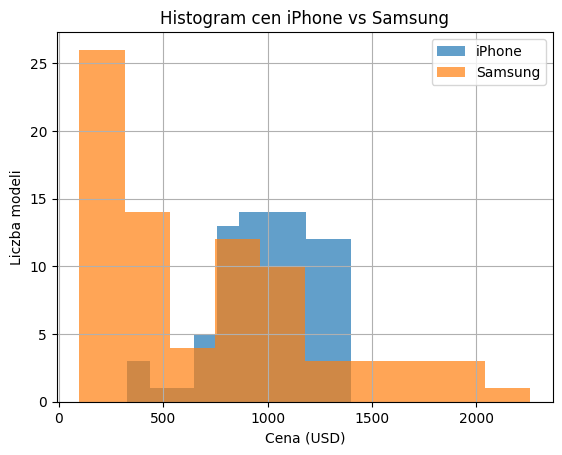

C:\Users\janpa\AppData\Local\Temp\ipykernel_26556\2758976612.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([iphone_prices, samsung_prices], labels=['iPhone', 'Samsung'])


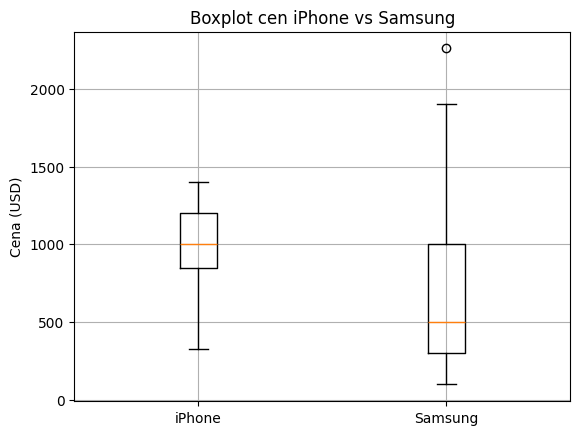

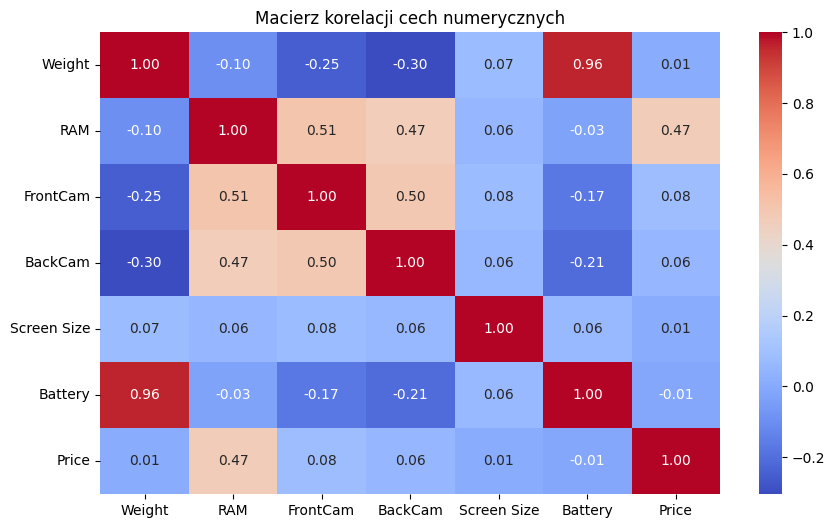

In [6]:
# Histogram cen Iphone vs Samsung 
plt.hist(iphone_prices, bins=10, alpha=0.7, label='iPhone')
plt.hist(samsung_prices, bins=10, alpha=0.7, label='Samsung')
plt.xlabel('Cena (USD)')
plt.ylabel('Liczba modeli')
plt.title('Histogram cen iPhone vs Samsung')
plt.legend()
plt.grid(True)
plt.show() 

# Boxplot cen iphone vs samsung 
plt.boxplot([iphone_prices, samsung_prices], labels=['iPhone', 'Samsung'])
plt.title('Boxplot cen iPhone vs Samsung')
plt.ylabel('Cena (USD)')
plt.grid(True)
plt.show()

# Wybieramy kolumny numeryczne
numeric_data = data_np[:, [2, 3, 4, 5, 7, 8, 9]].astype(float)

# Tworzymy DataFrame do korelacji
columns = ['Weight', 'RAM', 'FrontCam', 'BackCam', 'Screen Size', 'Battery', 'Price']
numeric_df = pd.DataFrame(numeric_data, columns=columns)

# Korelacja
corr_matrix = numeric_df.corr()

# Wizualizacja
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Macierz korelacji cech numerycznych')
plt.show()

In [ ]:
# usunięcie cech o niskiej wariacji 
selector = VarianceThreshold(threshold=0.01)
numerical_filtered = selector.fit_transform(numeric_data)

#Logarytmiczna transformacja ceny 
cleaned_df.loc[:, 'Price_log'] = np.log1p(cleaned_df['Launched Price (USA)']) 

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_filtered) 
cleaned_df = cleaned_df.drop(columns=['Price_log'])

# One-hot endocnding dla zmiennych kategorycznych 
encoded_df = pd.get_dummies(
    cleaned_df,
    columns=['Company Name','Model Name','Processor'],
    drop_first=True
)
X = encoded_df.drop('Launched Price (USA)', axis=1)
y = encoded_df['Launched Price (USA)']
print(encoded_df[(encoded_df['Company Name_Samsung'] == True) & 
                 (encoded_df['Model Name_Galaxy A54 128GB'] == True)])



     Mobile Weight  RAM  Front Camera  Back Camera  Battery Capacity  \
111          189.0  6.0          32.0         50.0            5000.0   

     Screen Size  Launched Price (USA)  Company Name_Google  \
111          6.4                 399.0                False   

     Company Name_Honor  Company Name_Huawei  ...  \
111               False                False  ...   

     Processor_Spreadtrum SC8830  Processor_Unisoc SC9832E  \
111                        False                     False   

     Processor_Unisoc SC9863A  Processor_Unisoc T606  Processor_Unisoc T610  \
111                     False                  False                  False   

     Processor_Unisoc T612  Processor_Unisoc T616  Processor_Unisoc T618  \
111                  False                  False                  False   

     Processor_Unisoc T700  Processor_Unisoc T760  
111                  False                  False  

[1 rows x 1082 columns]


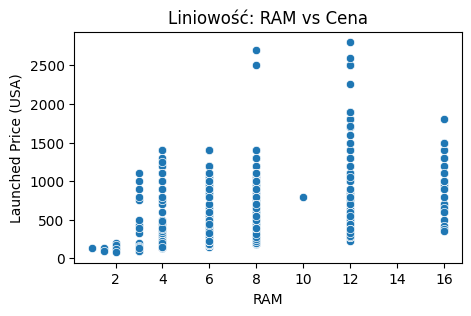

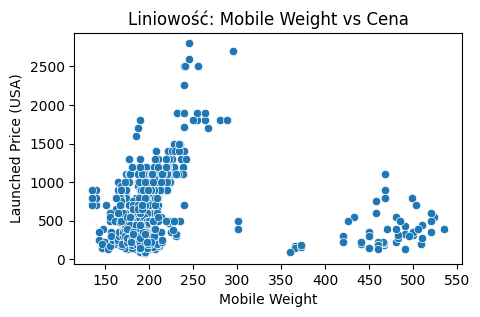

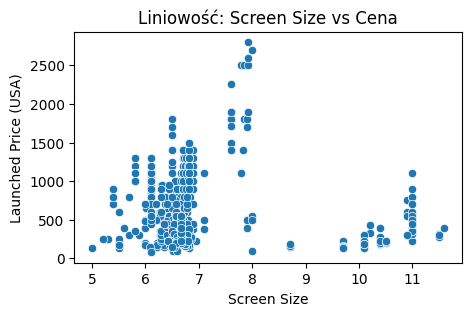

In [ ]:
# Sprawdzenie liniowości za pomocą wykresu rozrzutu

for col in ['RAM', 'Mobile Weight', 'Screen Size']:
    plt.figure(figsize=(5, 3))
    sns.scatterplot(data=cleaned_df, x=col, y='Launched Price (USA)')
    plt.title(f'Liniowość: {col} vs Cena')
    plt.show() 

 

In [ ]:
# Obliczenie wskaźniku VIF
X_no_const = cleaned_df[['RAM','Mobile Weight','Screen Size']]

X_with_const = sm.add_constant(X_no_const)

vif = pd.DataFrame({
    'feature': X_with_const.columns,
    'VIF': [
        variance_inflation_factor(X_with_const.values, i)
        for i in range(X_with_const.shape[1])
    ]
})

print(vif)


         feature         VIF
0          const  203.676678
1            RAM    1.078193
2  Mobile Weight   14.709167
3    Screen Size   14.575112


In [ ]:
X = encoded_df.drop('Launched Price (USA)', axis=1)
y = encoded_df['Launched Price (USA)']

# Podział na zbiór treningowy i testowy (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Trenowanie modelu
model = LinearRegression()
model.fit(X_train, y_train)

# Predykcja i ocena
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f}")

# kilka przykładowych porównań
comparison = X_test.copy()
comparison['y_true'] = y_test
comparison['y_prediction'] = y_pred
print(comparison[['y_true','y_prediction']].head())

Test RMSE: 183.92
     y_true  y_prediction
512   219.0    166.764755
357   549.0    567.212776
110  1099.0   1071.634585
684   349.0    350.680180
39    799.0    902.475806


In [ ]:
# Ewaulacja modelu 
print(X_train.dtypes[X_train.dtypes == 'object']) 
X_train = X_train.astype(float)
y_train = y_train.astype(float)


X_train = X_train.astype(float)
X_const = sm.add_constant(X_train)

model_sm = sm.OLS(y_train.astype(float), X_const).fit()
print(model_sm.summary())

# Ewaluacja na zbiorze testowym
X_test_const = sm.add_constant(X_test)
y_pred_sm = model_sm.predict(X_test_const)

mse_sm  = ((y_test - y_pred_sm)**2).mean()
rmse_sm = np.sqrt(mse_sm)
r2_sm   = r2_score(y_test, y_pred_sm)

print(f"\nstatsmodels Test R²:   {r2_sm:.3f}")
print(f"statsmodels Test RMSE: {rmse_sm:.3f}")

Series([], dtype: object)
                             OLS Regression Results                             
Dep. Variable:     Launched Price (USA)   R-squared:                       1.000
Model:                              OLS   Adj. R-squared:                    nan
Method:                   Least Squares   F-statistic:                       nan
Date:                  Tue, 10 Jun 2025   Prob (F-statistic):                nan
Time:                          20:35:06   Log-Likelihood:                 14367.
No. Observations:                   680   AIC:                        -2.737e+04
Df Residuals:                         0   BIC:                        -2.430e+04
Df Model:                           679                                         
Covariance Type:              nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

C:\Users\janpa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\janpa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\janpa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
C:\Users\janpa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\L